In [13]:
import requests
import pandas as pd
from io import StringIO

url = "https://digitallibrary.un.org/record/4060887/files/2025_7_23_ga_voting.csv?ln=en"

response = requests.get(url)


In [2]:
import os
import pandas as pd

# TODO: add vetoes, vetoes are not included atm
def fetch_UN_data(dir_path=None):
    """
    Fetches and processes United Nations General Assembly and Security Council voting data.
    
    This function retrieves voting data from either local files or the UN Digital Library,
    and transforms the data into two formats: original and pivoted (transformed).
    
    Parameters:
    -----------
    dir_path : str, optional
        Path to directory where data should be read from or saved to.
        If None, data will be fetched from the UN Digital Library and not saved locally.
    
    Returns:
    --------
    tuple
        A tuple containing four DataFrames:
        - df_ga: Original GA voting data
        - df_ga_transformed: Pivoted GA voting data with countries as columns
        - df_sc: Original SC voting data
        - df_sc_transformed: Pivoted SC voting data with countries as columns
    
    Notes:
    ------
    - Currently, the Security Council data does not include veto information explicitly.
    """

    df_ga = None
    df_sc = None

    if dir_path:
        try:
            df_ga = pd.read_csv(f"{dir_path}/2025_7_23_ga_voting.csv")
            df_sc = pd.read_csv(f"{dir_path}/2025_7_21_sc_voting.csv")
        except FileNotFoundError:
            print("Not all data found locally. Fetching from UN Digital Library...")
    if df_ga is None or df_sc is None:
        ga_url = "https://digitallibrary.un.org/record/4060887/files/2025_7_23_ga_voting.csv?ln=en"
        sc_url = "https://digitallibrary.un.org/record/4055387/files/2025_7_21_sc_voting.csv?ln=en"

        try:
            df_ga = pd.read_csv(ga_url)
            df_sc = pd.read_csv(sc_url)

            # Save data locally if dir_path is provided
            if dir_path:
                # Check if directory exists, create it if it doesn't
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                    print(f"Created directory: {dir_path}")
                
                df_ga.to_csv(f"{dir_path}/2025_7_23_ga_voting.csv", index=False)
                df_sc.to_csv(f"{dir_path}/2025_7_21_sc_voting.csv", index=False)
        except Exception as e:
            print("Error fetching data from UN Digital Library. The dataset might has been updated. Check the date in the URL.")
            print(f"Error: {e}")
            return None, None, None, None
    
    # Transform ga data
    ga_index_columns = ["undl_id", "date", "session", "resolution", "draft", "committee_report", "meeting", "title", "agenda_title", "subjects", "total_yes", "total_no", "total_abstentions", "total_non_voting", "total_ms", "undl_link"]
    df_ga_transformed = df_ga.pivot(index=ga_index_columns, columns='ms_code', values='ms_vote').reset_index()
    df_ga_transformed.columns.name = None

    # Transform sc data
    sc_index_columns = ["undl_id", "date", "resolution", "draft", "meeting", "description", "agenda", "subjects", "modality", "total_yes", "total_no", "total_abstentions", "total_non_voting", "total_ms", "undl_link"]
    df_sc_transformed = df_sc.pivot(index=sc_index_columns, columns='ms_code', values='ms_vote').reset_index()
    df_sc_transformed.columns.name = None

    return df_ga, df_ga_transformed, df_sc, df_sc_transformed


In [3]:
df_ga, df_ga_transformed, df_sc, df_sc_transformed = fetch_UN_data(dir_path="C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data")

C:\Users\janic\AppData\Local\Temp\ipykernel_13600\1467307482.py:37: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ga = pd.read_csv(f"{dir_path}/2025_7_23_ga_voting.csv")


In [ ]:
df_ga.columns.tolist()

# Display unique country codes and names

We want to check if there are country codes that map to multiple country names

In [ ]:
len(df_ga['ms_code'].unique())

In [ ]:
len(df_ga['ms_name'].unique())

In [ ]:
# Group by ms_code and collect all unique names associated with each code
ms_code_to_names = df_ga.groupby('ms_code')['ms_name'].unique().reset_index()

# Display number of codes with multiple names
multiple_names_mask = ms_code_to_names['ms_name'].apply(len) > 1
multiple_names_count = multiple_names_mask.sum()

print(f"Total unique country codes: {len(ms_code_to_names)}")
print(f"Country codes with multiple names: {multiple_names_count}")

# Display codes with multiple names
if multiple_names_count > 0:
    print("\nCountry codes with multiple associated names:")
    for _, row in ms_code_to_names[multiple_names_mask].iterrows():
        print(f"{row['ms_code']}: {', '.join(row['ms_name'])}")

In [ ]:
# Create a DataFrame with country codes and names
country_mapping = []
for _, row in ms_code_to_names.iterrows():
    code = row['ms_code']
    names = row['ms_name']
    # If it's a list with one element, just take that element
    if len(names) == 1:
        country_mapping.append({'Code': code, 'Name': names[0]})
    else:
        # For multiple names, join them with ' / '
        country_mapping.append({'Code': code, 'Name': ' / '.join(names)})

# Convert to DataFrame and display
country_df = pd.DataFrame(country_mapping)
country_df = country_df.sort_values('Code')

# Display with nice formatting
print(f"Total countries: {len(country_df)}\n")
for i, row in country_df.iterrows():
    print(f"{row['Code']}: {row['Name']}")

33 Countries have multiple names for the same country code. 

However one example that I noticed is that Yugoslavia (YUG) and Russian Federation (RUS) have separate country codes!

# Moving average of votes over time

So the idea here is to specify a time range that should be used for the moving average (say 6 months) and then for two specified countries (say USA and China) plot the moving average of agreement between these two countriess over time. Agreement for a vote $v$ is defined as:

$$
S_{v} = 1 - \frac{|V_{A,v} - V_{B,v}|}{2}
$$

We then calculate a moving average (simple, exponential, cumulative) over all votes in the specified time range. $V_{A,v}$ is one of the following three values {1 (yes), 0 (abstain), -1 (no)}, and specifies the vote of country A on resolution $v$.

Alternatively we can use the following definition from [this paper](https://www.notion.so/UN-Policy-Pulse-22ae9b7371948081bfc2dce6630b52d5?source=copy_link#24ce9b737194809ca64fead337e14857)

$$
S_{A,B} = 1 - \frac{\sum |v_{A,i} - v_{B,i}|}{N}
$$


where $v_{A,i}$ is the vote of country A on resolution i, $v_{B,i}$ is the vote of country B on resolution i, and $N$ is the total number of resolutions both countries voted on in the specified time range.


TODO:
- What to do with missing values? 
- Change name codes to names
- Use plotly for interactive plots -> dash app
- add option for groups
- add option for sessions
- add options to include ga/sc
- hower over missing values should give some information, figure out what

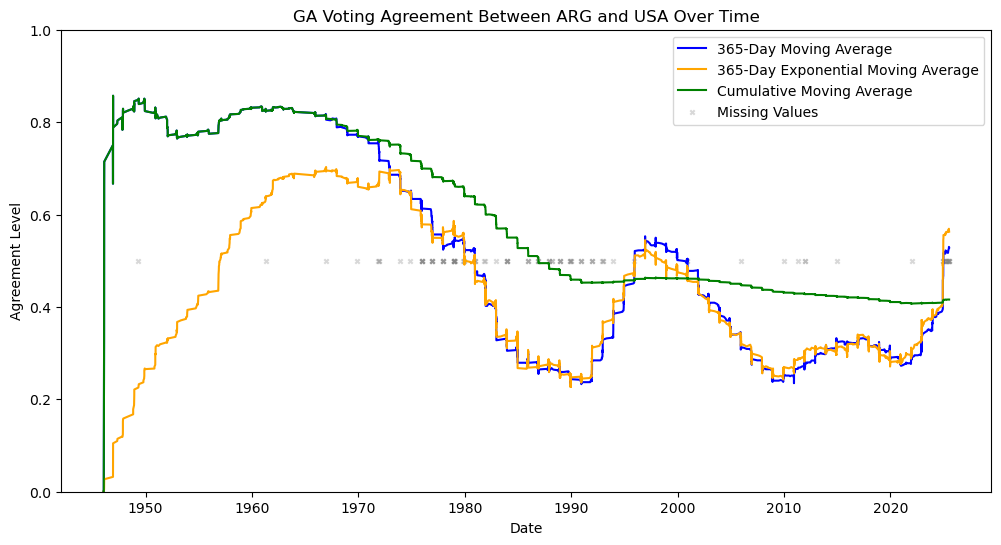

In [10]:
# Matplotlib version

import matplotlib.pyplot as plt

countries = ['ARG', 'USA']
time_span = 365 # days
start_date = None
end_date = None

def moving_average(df, countries, time_span=365, start_date=None, end_date=None):
    """Calculate moving average of agreement between two countries over time."""

    df_ma = df[["undl_id", "date"] + countries].copy()

    def calc_agreement(row, countries): # Current version only supports 2 countries
        # Map vote values to numeric values for calculation
        vote_mapping = {"Y": 1, "A": 0, "N": -1}
        
        # Check if both countries have valid votes
        if row[countries[0]] in vote_mapping and row[countries[1]] in vote_mapping:
            # Calculate the absolute difference between votes
            diff = abs(vote_mapping[row[countries[0]]] - vote_mapping[row[countries[1]]])
            # Calculate agreement value (1 - diff/2)
            # Max difference is 2, so we divide by 2 to normalize to [0,1]
            agreement = 1 - (diff / 2)
            return agreement
        else:
            # Return NaN if either country didn't vote or had an invalid vote
            return float('nan')

    # Calculate agreement
    df_ma['agreement'] = df_ma.apply(lambda row: calc_agreement(row, countries), axis=1)
    df_ma['date'] = pd.to_datetime(df_ma['date'])
    df_ma = df_ma.sort_values('date')

    # Filter for start_date and end_date
    if start_date:
        df_ma = df_ma[df_ma['date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_ma = df_ma[df_ma['date'] <= pd.to_datetime(end_date)]

    # Fill out missing values
    # df_ma = df_ma.fillna(method='ffill') # We need to figure out what to do with missing values

    # Calculate moving averages
    df_ma['agreement_sma'] = df_ma['agreement'].rolling(window=time_span, min_periods=1).mean()
    df_ma['agreement_ema'] = df_ma['agreement'].ewm(span=time_span, adjust=False).mean()
    df_ma['agreement_cma'] = df_ma['agreement'].expanding(min_periods=1).mean()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_ma['date'], df_ma['agreement_sma'], label=f'{time_span}-Day Moving Average', color='blue')
    plt.plot(df_ma['date'], df_ma['agreement_ema'], label=f'{time_span}-Day Exponential Moving Average', color='orange')
    plt.plot(df_ma['date'], df_ma['agreement_cma'], label=f'Cumulative Moving Average', color='green')
    
    # # Add scatter plot for daily agreement values
    # # Use masked array to avoid plotting NaN values with red dots
    # #mask = ~pd.isna(df_ma['agreement'])
    # #plt.scatter(df_ma['date'][mask], df_ma['agreement'][mask], label='Daily Agreement', color='red', alpha=0.3, s=10)
    
    # # Mark missing values with a different symbol and color
    mask_na = pd.isna(df_ma['agreement'])
    if mask_na.any():
        plt.scatter(df_ma['date'][mask_na], [0.5] * mask_na.sum(), label='Missing Values', 
                   color='gray', marker='x', alpha=0.3, s=10)
        
    
    plt.xlabel('Date')
    plt.ylabel('Agreement Level')
    plt.title(f'GA Voting Agreement Between {countries[0]} and {countries[1]} Over Time')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

moving_average(df_ga_transformed, countries, time_span=time_span, start_date=start_date, end_date=end_date)

In [ ]:
# Plotly version
import plotly.graph_objects as go

countries = ['ARG', 'USA']
time_span = 365 # days
start_date = None
end_date = None

def moving_average(df, countries, time_span=365, start_date=None, end_date=None):
    """Calculate moving average of agreement between two countries over time."""

    df_ma = df[["undl_id", "date"] + countries].copy()

    def calc_agreement(row, countries): # Current version only supports 2 countries
        # Map vote values to numeric values for calculation
        vote_mapping = {"Y": 1, "A": 0, "N": -1}
        
        # Check if both countries have valid votes
        if row[countries[0]] in vote_mapping and row[countries[1]] in vote_mapping:
            # Calculate the absolute difference between votes
            diff = abs(vote_mapping[row[countries[0]]] - vote_mapping[row[countries[1]]])
            # Calculate agreement value (1 - diff/2)
            # Max difference is 2, so we divide by 2 to normalize to [0,1]
            agreement = 1 - (diff / 2)
            return agreement
        else:
            # Return NaN if either country didn't vote or had an invalid vote
            return float('nan')

    # Calculate agreement
    df_ma['agreement'] = df_ma.apply(lambda row: calc_agreement(row, countries), axis=1)
    df_ma['date'] = pd.to_datetime(df_ma['date'])
    df_ma = df_ma.sort_values('date')

    # Filter for start_date and end_date
    if start_date:
        df_ma = df_ma[df_ma['date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_ma = df_ma[df_ma['date'] <= pd.to_datetime(end_date)]

    # Fill out missing values
    # df_ma = df_ma.fillna(method='ffill') # We need to figure out what to do with missing values

    # Calculate moving averages
    df_ma['agreement_sma'] = df_ma['agreement'].rolling(window=time_span, min_periods=1).mean()
    df_ma['agreement_ema'] = df_ma['agreement'].ewm(span=time_span, adjust=False).mean()
    df_ma['agreement_cma'] = df_ma['agreement'].expanding(min_periods=1).mean()

    mask_na = pd.isna(df_ma['agreement'])
    # Create figure
    fig = go.Figure()

    # Add traces for the different moving averages
    fig.add_trace(
        go.Scatter(
            x=df_ma['date'], 
            y=df_ma['agreement_sma'], 
            mode='lines', 
            name=f'{time_span}-Day Moving Average',
            line=dict(color='blue')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_ma['date'], 
            y=df_ma['agreement_ema'], 
            mode='lines', 
            name=f'{time_span}-Day Exponential Moving Average',
            line=dict(color='orange')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_ma['date'], 
            y=df_ma['agreement_cma'], 
            mode='lines', 
            name='Cumulative Moving Average',
            line=dict(color='green')
        )
    )

    # Add scatter points for missing values if any exist
    if mask_na.any():
        fig.add_trace(
            go.Scatter(
                x=df_ma['date'][mask_na], 
                y=[0.5] * mask_na.sum(), 
                mode='markers', 
                name='Missing Values',
                marker=dict(color='gray', symbol='x', size=8),
                opacity=0.3
            )
        )

    # Update layout
    fig.update_layout(
        title=f'GA Voting Agreement Between {countries[0]} and {countries[1]} Over Time',
        xaxis_title='Date',
        yaxis_title='Agreement Level',
        yaxis=dict(range=[0, 1]),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        template="plotly_white",
        hovermode="x unified"
    )

    # Show figure
    fig.show()

moving_average(df_ga_transformed, countries, time_span=time_span, start_date=start_date, end_date=end_date)

# UNBIS Thesaurus and session topics analysis

TODO:
1. Parse the subjects reasonably
2. Check how many subjects are in the thesaurus
3. Check for the ones that are not if it's a parsing issue or if it is actually something different

In [2]:
import pandas as pd


df_ga = pd.read_csv("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\2025_7_23_ga_voting.csv")
df_thesaurus = pd.read_csv("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\unbist-20250708.csv")

C:\Users\janic\AppData\Local\Temp\ipykernel_11532\2097752669.py:4: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ga = pd.read_csv("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\2025_7_23_ga_voting.csv")


## Parsing subjects

Some subjects have the form "{Topic}--{Subtopic/Detail}".
Some subjects have the form "{Topic}|{Topic}", in this case I assume that this is how multiple subjects are encoded.

So current plan: Split for "|" first, then split for "--" and take the first part.

In [17]:
# Parsing subjects

print("Total unique unprocessed subjects in GA data: ", len(df_ga['subjects'].unique()))
print(df_ga['subjects'].unique()[:5]) # Print first 5 unique subjects



Total unique unprocessed subjects in GA data:  437
['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS--TREATIES'
 'DISARMAMENT--GENERAL AND COMPLETE' 'NAMIBIA QUESTION'
 'DECOLONIZATION--UN SYSTEM|UN. ECONOMIC AND SOCIAL COUNCIL--REPORTS']


In [18]:
temp_subjects = df_ga['subjects'].str.split('|').explode()
print("Total unique subjects after splitting at '|': ", len(temp_subjects.unique()))
print(temp_subjects.unique()[:5]) # Print first 5 unique subjects after splitting


Total unique subjects after splitting at '|':  397
['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS--TREATIES'
 'DISARMAMENT--GENERAL AND COMPLETE' 'NAMIBIA QUESTION'
 'DECOLONIZATION--UN SYSTEM']


In [ ]:
subjects = temp_subjects.str.split('--').str[0].str.strip().unique()
print("Total unique subjects after further splitting at '--': ", len(subjects))
print(subjects[:5])


Total unique subjects after further splitting at '--' and cleaning:  249
['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS' 'DISARMAMENT'
 'NAMIBIA QUESTION' 'DECOLONIZATION']


In [21]:
# Maybe interesting to see what the second part after the "--" is, maybe it is relevant
subject_suffix = temp_subjects.str.split('--').str[1].str.strip()
print("Total unique second parts after splitting at '--': ", len(subject_suffix.unique()))
print(subject_suffix.unique()[:5]) # Print first 5 unique second parts after splitting

Total unique second parts after splitting at '--':  163
[nan 'TREATIES' 'GENERAL AND COMPLETE' 'UN SYSTEM' 'REPORTS']


## Checking subjects for thesaurus matches

Now we check how many of the parsed subjects are in the thesaurus

In [24]:
# get thesaurus labels
thesaurus_labels = df_thesaurus['prefLabel'].unique()

print(thesaurus_labels[:10])

['GEOGRAPHY' 'GEOGRAFIA' 'GEOGRAPHIE' 'ГЕОГРАФИЯ' '地理' 'الجغرافيا'
 'رسم الخرائط' 'CARTOGRAPHY' 'CARTOGRAFIA' 'CARTOGRAPHIE']


In [26]:
# Check for the subjects in the thesaurus

# Convert both arrays to sets for faster lookup
ga_subjects_set = set(subjects) - {None}  # Remove None values
thesaurus_labels_set = set(thesaurus_labels)

# Find matches
matches = ga_subjects_set.intersection(thesaurus_labels_set)

# Find subjects not in thesaurus
not_in_thesaurus = ga_subjects_set - thesaurus_labels_set

# Print results
print(f"Total unique GA subjects: {len(ga_subjects_set)}")
print(f"Total unique thesaurus labels: {len(thesaurus_labels_set)}")
print(f"Number of direct matches: {len(matches)}")
print(f"Percentage of GA subjects found in thesaurus: {len(matches)/len(ga_subjects_set)*100:.2f}%")

# Display the first 20 matches
#print("\nSample matches:")
#for match in list(matches)[:20]:
#    print(f"- {match}")

# Display the first 20 non-matches
print("\nSample GA subjects not found in thesaurus:")
for subject in list(not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total unique GA subjects: 249
Total unique thesaurus labels: 42675
Number of direct matches: 176
Percentage of GA subjects found in thesaurus: 70.68%

Sample GA subjects not found in thesaurus:
- UN. SECRETARIAT
- NUCLEAR DISARMAMENT NEGOTIATIONS
- UN INTERIM FORCE IN LEBANON
- UN. GENERAL ASSEMBLY (66TH SESS. : 2011-2012). CREDENTIALS COMMITTEE
- ASSOCIATION OF SOUTHEAST ASIAN NATIONS
- UN CHARTER
- 2030 AGENDA
- PEACE AND SECURITY
- UN SYSTEM
- MILLENNIUM SUMMIT
- UN RESOLUTIONS
- MEDITERRANEAN-DEAD SEA CANAL PROJECT
- UNIFIL
- CENTRAL ASIAN
- COLLECTIVE SECURITY TREATY ORGANIZATION
- KAMPUCHEA SITUATION
- UN. OFFICE OF THE HIGH COMMISSIONER FOR HUMAN RIGHTS
- LIBYAN ARAB JAMAHIRIYA
- PACIFIC ISLANDS FORUM
- COUNCIL OF EUROPE


In [29]:
# Check if some suffixes are in the thesaurus

# Convert both arrays to sets for faster lookup
ga_subjects_suffix_set = set(subject_suffix) - {None}  # Remove None values
thesaurus_labels_set = set(thesaurus_labels)

# Find matches
matches = ga_subjects_suffix_set.intersection(thesaurus_labels_set)

# Find subjects not in thesaurus
not_in_thesaurus = ga_subjects_suffix_set - thesaurus_labels_set

# Print results
print(f"Total unique GA suffixes: {len(ga_subjects_suffix_set)}")
print(f"Total unique thesaurus labels: {len(thesaurus_labels_set)}")
print(f"Number of direct matches: {len(matches)}")
print(f"Percentage of GA suffixes found in thesaurus: {len(matches)/len(ga_subjects_suffix_set)*100:.2f}%")

# Display the first 20 matches
print("\nSample matches:")
for match in list(matches)[:20]:
    print(f"- {match}")

# Display the first 20 non-matches
print("\nSample GA suffixes not found in thesaurus:")
for subject in list(not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total unique GA suffixes: 163
Total unique thesaurus labels: 42675
Number of direct matches: 79
Percentage of GA suffixes found in thesaurus: 48.47%

Sample matches:
- PENSIONS
- PRINCIPLES
- LAWS AND REGULATIONS
- OBSERVER STATUS
- FOREIGN INTERESTS
- OLYMPIC GAMES
- INTERNATIONAL RELATIONS
- INTERDEPENDENCE
- ACTIVITIES
- DEMOCRATIC REPUBLIC OF THE CONGO
- HUMAN RIGHTS
- UKRAINE
- ADMINISTRATION
- NUCLEAR-WEAPON-FREE ZONES
- BUDGET CONTRIBUTIONS
- LEBANON
- MYANMAR
- DISARMAMENT
- INTERNATIONAL SECURITY
- FAMILY REUNIFICATION

Sample GA suffixes not found in thesaurus:
- UN. GENERAL ASSEMBLY (4TH SPECIAL SESS. ON DISARMAMENT : xxxx)
- MEDITERRANEAN-DEAD SEA CANAL PROJECT
- DECLARATIONS (1960)
- TREATIES (1966)
- CODE OF CRIMES (DRAFT)
- BUDGET (2010-2011)
- COMPREHENSIVE SYSTEM
- ECONOMIC INTERESTS
- ADVANCEMENT
- PEACEFUL USES
- DECLARATIONS (1970)
- UN. GENERAL ASSEMBLY (15TH SPECIAL SESS. : 1988)
- ASSISTANCE
- CESSATION
- REVIEW
- INTERNATIONAL DECADES (1991-2000)
- PROTECTION
- 

Of the primary subjects we have 70% in the thesaurus
Of the suffixes we have 48% in the thesaurus

So maybe we want a combination?

In [ ]:
# Check for how many presplit subjects neither the primary subject nor the suffix is in the thesaurus

# Split subjects by "--" and check all parts
subjects_not_in_thesaurus = []

for subject in temp_subjects:
    if isinstance(subject, str):
        # Split by pipe first to handle multiple subjects
        parts = subject.split('--')
        
        has_atleast_one_part = False

        for part in parts:
            if part.strip() in thesaurus_labels_set:
                has_atleast_one_part = True
                break
        
        if not has_atleast_one_part:
            subjects_not_in_thesaurus.append(subject)

# Remove duplicates
subjects_not_in_thesaurus = list(set(subjects_not_in_thesaurus))

# Display results
print(f"Total subjects where neither primary nor suffix is in thesaurus: {len(subjects_not_in_thesaurus)}")
print(f"Percentage of such subjects: {len(subjects_not_in_thesaurus)/len(temp_subjects.unique())*100:.2f}%")
print("\nSample of subjects not found in thesaurus (first 20):")
for subject in sorted(subjects_not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total subjects where neither primary nor suffix is in thesaurus: 69
Percentage of such subjects: 17.38%

Sample of subjects not found in thesaurus (first 20):
- ARMED CONFLICTS PREVENTION
- ASSOCIATION OF SOUTHEAST ASIAN NATIONS--UN
- AUTONOMOUS WEAPONS
- AZERBAIJAN SITUATION
- CENTRAL ASIAN--UCLEAR-WEAPON-FREE ZONE
- CENTRAL EUROPEAN INITIATIVE--UN
- CHAGOS ARCHIPELAGO--UN. INTERNATIONAL COURT OF JUSTICE OPINION
- CLONING OF HUMAN BEINGS--TREATIES (PROPOSED)
- COLLECTIVE SECURITY
- COLLECTIVE SECURITY TREATY ORGANIZATION--UN
- COUNCIL OF EUROPE--UN
- ECONOMIC COOPERATION ORGANIZATION--UN
- IAEA--REPORTS
- INTERNATIONAL CRIMINAL COURT--REPORTS
- KAMPUCHEA SITUATION
- KOSOVO--UN. INTERNATIONAL COURT OF JUSTICE OPINION
- LEAGUE OF ARAB STATES--UN
- MEDITERRANEAN-DEAD SEA CANAL PROJECT
- MULTILATERAL TREATIES--DRAFTING PROCESS
- NATURE


So if we loosen our matching criteria we end up with ~82% of subjects in the thesaurus.

1. So there are still quite some uncategorized subjects
2. After looking into them, it looks like there has been some variance in the naming. Example : "Cloning of Human beings" has no match, but there is "Human cloning" in the thesaurus.

How do we continue?
1. We could try more advanced matching
2. We could ignore the thesaurus and just use the subjects as they are and use them as grouping criteria
3. We could ignore the subjects that are not included in the thesaurus
4. We could look at other metadata fields (session topics, agenda etc.) for backup categorization -> don't think it will help much
5. Another issue is that we also have quite some resolutions without any subjects
6. Also if we just look at the primary subjects we already have ~250 unique subjects, which are already quite hard to overview? If we take only the thesaurus matches we get ~180. So a grouping of subjects would be helpful.

-> there's a hierarchy in the thesaurus, maybe we can use that one to group subjects? And then make advanced and simple groups available to endusers?

## Understanding the thesaurus hierarchy

The thesaurus provides rdf and ttl files, which represent graphs and the hierarchy present in the thesaurus. Let's try to work with the files and see if we can group the subjects.

In [57]:
# Let's check the other file format too
from rdflib import Graph, Namespace, RDF, RDFS, SKOS
from collections import defaultdict

# Load the file (works for both RDF and TTL)
g = Graph()
g.parse("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\unbist-20250708_2.ttl", format="turtle")  # or .rdf with format="xml"

print(f"Loaded {len(g)} triples")

# Explore namespaces used
print("\nNamespaces:")
for prefix, namespace in g.namespaces():
    print(f"{prefix}: {namespace}")

Loaded 184729 triples

Namespaces:
brick: https://brickschema.org/schema/Brick#
csvw: http://www.w3.org/ns/csvw#
dc: http://purl.org/dc/elements/1.1/
dcat: http://www.w3.org/ns/dcat#
dcmitype: http://purl.org/dc/dcmitype/
dcam: http://purl.org/dc/dcam/
doap: http://usefulinc.com/ns/doap#
foaf: http://xmlns.com/foaf/0.1/
geo: http://www.opengis.net/ont/geosparql#
odrl: http://www.w3.org/ns/odrl/2/
org: http://www.w3.org/ns/org#
prof: http://www.w3.org/ns/dx/prof/
prov: http://www.w3.org/ns/prov#
qb: http://purl.org/linked-data/cube#
schema: https://schema.org/
sh: http://www.w3.org/ns/shacl#
skos: http://www.w3.org/2004/02/skos/core#
sosa: http://www.w3.org/ns/sosa/
ssn: http://www.w3.org/ns/ssn/
time: http://www.w3.org/2006/time#
vann: http://purl.org/vocab/vann/
void: http://rdfs.org/ns/void#
wgs: https://www.w3.org/2003/01/geo/wgs84_pos#
owl: http://www.w3.org/2002/07/owl#
rdf: http://www.w3.org/1999/02/22-rdf-syntax-ns#
rdfs: http://www.w3.org/2000/01/rdf-schema#
xsd: http://www.w3.

In [ ]:
# Cell 2: Extract concept schemes first
def get_concept_schemes():
    schemes = []
    for scheme in g.subjects(RDF.type, SKOS.ConceptScheme):
        labels = list(g.objects(scheme, SKOS.prefLabel))
        label_en = next((str(l) for l in labels if hasattr(l, 'language') and l.language == 'en'), 
                       str(labels[0]) if labels else str(scheme).split('/')[-1])
        
        schemes.append({
            'uri': str(scheme),
            'label': label_en,
            'type': 'scheme'
        })
    
    return pd.DataFrame(schemes)

schemes_df = get_concept_schemes()
print(f"Found {len(schemes_df)} concept scheme(s)")
schemes_df

Found 19 concept scheme(s)


,uri,label,type
0,http://metadata.un.org/thesaurus/03,NATURAL RESOURCES AND THE ENVIRONMENT,scheme
1,http://metadata.un.org/thesaurus/14,SOCIAL CONDITIONS AND EQUITY,scheme
2,http://metadata.un.org/thesaurus/02,ECONOMIC DEVELOPMENT AND DEVELOPMENT FINANCE,scheme
3,http://metadata.un.org/thesaurus/15,CULTURE,scheme
4,http://metadata.un.org/thesaurus/05,INDUSTRY,scheme
5,http://metadata.un.org/thesaurus/01,POLITICAL AND LEGAL QUESTIONS,scheme
6,http://metadata.un.org/thesaurus/00,UNBIS Thesaurus,scheme
7,http://metadata.un.org/thesaurus/04,"AGRICULTURE, FORESTRY AND FISHING",scheme
8,http://metadata.un.org/thesaurus/06,TRANSPORT AND COMMUNICATIONS,scheme
9,http://metadata.un.org/thesaurus/07,INTERNATIONAL TRADE,scheme


In [ ]:
# Cell 3: Build complete hierarchy with schemes
def build_complete_hierarchy():
    rows = []
    
    # First, add all concept schemes at depth 0
    scheme_uris = set()
    for scheme in g.subjects(RDF.type, SKOS.ConceptScheme):
        labels = list(g.objects(scheme, SKOS.prefLabel))
        label_en = next((str(l) for l in labels if hasattr(l, 'language') and l.language == 'en'), 
                       str(labels[0]) if labels else '')
        
        scheme_uri = str(scheme)
        scheme_uris.add(scheme_uri)
        
        # Get top concepts of this scheme
        top_concepts = list(g.objects(scheme, SKOS.hasTopConcept))
        
        rows.append({
            'uri': scheme_uri,
            'label': label_en,
            'type': 'scheme',
            'is_top_concept': False,
            'depth': 0,
            'has_children': len(top_concepts) > 0,
            'parent_uri': None,
            'scheme_uri': scheme_uri,
            'all_children': '|'.join([str(tc) for tc in top_concepts]),
            'path': scheme_uri
        })
    
    # Now process all concepts
    for concept in g.subjects(RDF.type, SKOS.Concept):
        concept_uri = str(concept)
        
        # Get basic info
        labels = list(g.objects(concept, SKOS.prefLabel))
        label_en = next((str(l) for l in labels if hasattr(l, 'language') and l.language == 'en'), 
                       str(labels[0]) if labels else '')
        
        # Get hierarchy info
        broader = [str(b) for b in g.objects(concept, SKOS.broader)]
        narrower = [str(n) for n in g.objects(concept, SKOS.narrower)]
        
        # Check if this is a top concept (directly under a scheme)
        parent_schemes = list(g.subjects(SKOS.hasTopConcept, concept))
        is_top = len(parent_schemes) > 0
        
        # Determine parent and scheme
        if is_top:
            parent_uri = str(parent_schemes[0])
            scheme_uri = parent_uri
            depth = 1
        elif broader:
            parent_uri = broader[0]
            # Find scheme by traversing up
            current = concept
            scheme_uri = None
            depth = 1
            for _ in range(20):  # Safety limit
                broader_terms = list(g.objects(current, SKOS.broader))
                if not broader_terms:
                    # Check if current is a top concept
                    schemes = list(g.subjects(SKOS.hasTopConcept, current))
                    if schemes:
                        scheme_uri = str(schemes[0])
                    break
                current = broader_terms[0]
                depth += 1
        else:
            parent_uri = None
            scheme_uri = None
            depth = 0
        
        # Build path from scheme to this concept
        path_parts = [concept_uri]
        current = concept
        for _ in range(20):
            broader_terms = list(g.objects(current, SKOS.broader))
            if not broader_terms:
                break
            current = broader_terms[0]
            path_parts.insert(0, str(current))
        
        # Add scheme to path if found
        if scheme_uri:
            path_parts.insert(0, scheme_uri)
        
        rows.append({
            'uri': concept_uri,
            'label': label_en,
            'type': 'concept',
            'is_top_concept': is_top,
            'depth': depth,
            'has_children': len(narrower) > 0,
            'parent_uri': parent_uri,
            'scheme_uri': scheme_uri,
            'all_parents': '|'.join(broader),
            'all_children': '|'.join(narrower),
            'path': '|'.join(path_parts)
        })
    
    return pd.DataFrame(rows)

hierarchy_df = build_complete_hierarchy()

hierarchy_df = hierarchy_df[hierarchy_df['label'] != 'UNBIS Thesaurus']

In [ ]:
# Cell 4: Verify the structure
print(f"Total nodes: {len(hierarchy_df)}")
print(f"\nBreakdown by type:")
print(hierarchy_df['type'].value_counts())

print(f"\nBreakdown by depth:")
print(hierarchy_df['depth'].value_counts().sort_index())

print(f"\nConcept schemes:")
print(hierarchy_df[hierarchy_df['type'] == 'scheme'][['label', 'has_children']])

Total nodes: 7341

Breakdown by type:
type
concept    7322
scheme       19
Name: count, dtype: int64

Breakdown by depth:
depth
0      19
1     143
2    6818
3     354
4       7
Name: count, dtype: int64

Concept schemes:
                                           label  has_children
0          NATURAL RESOURCES AND THE ENVIRONMENT          True
1                   SOCIAL CONDITIONS AND EQUITY          True
2   ECONOMIC DEVELOPMENT AND DEVELOPMENT FINANCE          True
3                                        CULTURE          True
4                                       INDUSTRY          True
5                  POLITICAL AND LEGAL QUESTIONS          True
6                                UNBIS Thesaurus         False
7              AGRICULTURE, FORESTRY AND FISHING          True
8                   TRANSPORT AND COMMUNICATIONS          True
9                            INTERNATIONAL TRADE          True
10                                    POPULATION          True
11                    

In [ ]:
# Cell 5: Check top concepts under each scheme
schemes = hierarchy_df[hierarchy_df['type'] == 'scheme']

for _, scheme in schemes.iterrows():
    top_concepts = hierarchy_df[hierarchy_df['parent_uri'] == scheme['uri']]
    print(f"\n{scheme['label']} ({scheme['uri']})")
    print(f"  Has {len(top_concepts)} top-level concepts:")
    for _, tc in top_concepts.head(5).iterrows():
        print(f"    - {tc['label']}")
    if len(top_concepts) > 5:
        print(f"    ... and {len(top_concepts) - 5} more")


NATURAL RESOURCES AND THE ENVIRONMENT (http://metadata.un.org/thesaurus/03)
  Has 12 top-level concepts:
    - GEOGRAPHY
    - CARTOGRAPHY
    - LAND FORMS AND ECOSYSTEMS
    - RESOURCES (GENERAL)
    - ENVIRONMENT
    ... and 7 more

SOCIAL CONDITIONS AND EQUITY (http://metadata.un.org/thesaurus/14)
  Has 10 top-level concepts:
    - WOMEN'S ADVANCEMENT
    - DISCRIMINATION
    - HUMAN RIGHTS
    - GENEALOGY AND EMBLEMS
    - NARCOTIC DRUGS
    ... and 5 more

ECONOMIC DEVELOPMENT AND DEVELOPMENT FINANCE (http://metadata.un.org/thesaurus/02)
  Has 13 top-level concepts:
    - ECONOMIC THEORY
    - ECONOMIC CONDITIONS
    - SPECIAL ECONOMIC AREAS
    - DEVELOPMENT
    - PUBLIC ADMINISTRATION
    ... and 8 more

CULTURE (http://metadata.un.org/thesaurus/15)
  Has 8 top-level concepts:
    - CULTURAL DEVELOPMENT
    - LANGUAGE
    - ART, LITERATURE AND MUSIC
    - PROTECTION OF INTELLECTUAL AND CULTURAL PROPERTY
    - PHILOSOPHY AND RELIGION
    ... and 3 more

INDUSTRY (http://metadata

In [ ]:
# Cell 6: Verify "Education" is properly connected
education_uri = "http://metadata.un.org/thesaurus/11"
education = hierarchy_df[hierarchy_df['uri'] == education_uri]

if not education.empty:
    edu = education.iloc[0]
    print(f"Label: {edu['label']}")
    print(f"Type: {edu['type']}")
    print(f"Is top concept: {edu['is_top_concept']}")
    print(f"Depth: {edu['depth']}")
    print(f"Parent URI: {edu['parent_uri']}")
    print(f"Scheme URI: {edu['scheme_uri']}")
    print(f"Has children: {edu['has_children']}")
    
    # Show parent
    if edu['parent_uri']:
        parent = hierarchy_df[hierarchy_df['uri'] == edu['parent_uri']]
        if not parent.empty:
            print(f"\nParent: {parent.iloc[0]['label']} ({parent.iloc[0]['type']})")

Label: EDUCATION
Type: scheme
Is top concept: False
Depth: 0
Parent URI: None
Scheme URI: http://metadata.un.org/thesaurus/11
Has children: True


In [ ]:
# Cell 7: Save the complete hierarchy
#hierarchy_df.to_parquet('unbis_hierarchy_complete.parquet')
hierarchy_df.to_csv('unbis_hierarchy_complete.csv', index=False)

print("Saved complete hierarchy with concept schemes!")

Saved complete hierarchy with concept schemes!


In [ ]:
# Cell 8: Quick access function for getting children
def get_children(parent_uri):
    """Get immediate children of a node (scheme or concept)"""
    children = hierarchy_df[hierarchy_df['parent_uri'] == parent_uri]
    return children[['uri', 'label', 'type', 'has_children', 'depth']].sort_values('label')

# Test with a scheme
scheme_uri = schemes_df.iloc[0]['uri']
print(f"Children of {schemes_df.iloc[0]['label']}:")
get_children(scheme_uri).head()

Children of NATURAL RESOURCES AND THE ENVIRONMENT:


,uri,label,type,has_children,depth
20,http://metadata.un.org/thesaurus/030102,CARTOGRAPHY,concept,True,1
30,http://metadata.un.org/thesaurus/031000,ENERGY RESOURCES,concept,True,1
23,http://metadata.un.org/thesaurus/030300,ENVIRONMENT,concept,True,1
19,http://metadata.un.org/thesaurus/030101,GEOGRAPHY,concept,True,1
21,http://metadata.un.org/thesaurus/030103,LAND FORMS AND ECOSYSTEMS,concept,True,1


In [74]:
# Cell 13: Print tree for each concept scheme
def print_tree(node_uri, visited=None, depth=0, max_depth=10, prefix="", is_last=True):
    """Recursively print tree structure"""
    if visited is None:
        visited = set()
    
    if node_uri in visited or depth > max_depth:
        return
    
    visited.add(node_uri)
    
    # Get node info
    node = hierarchy_df[hierarchy_df['uri'] == node_uri]
    if node.empty:
        return
    
    node_data = node.iloc[0]
    label = node_data['label']
    node_type = node_data['type']
    
    # Print current node with appropriate connector
    if depth == 0:
        print(f"\n{'='*80}")
        print(f"{label} [{node_type}]")
        print(f"{'='*80}")
    else:
        connector = "└── " if is_last else "├── "
        print(f"{prefix}{connector}{label}")
    
    # Get children
    children = hierarchy_df[hierarchy_df['parent_uri'] == node_uri].sort_values('label')
    
    if len(children) == 0:
        return
    
    # Print children
    for idx, (_, child) in enumerate(children.iterrows()):
        is_last_child = (idx == len(children) - 1)
        
        if depth == 0:
            new_prefix = ""
        else:
            extension = "    " if is_last else "│   "
            new_prefix = prefix + extension
        
        print_tree(child['uri'], visited, depth + 1, max_depth, new_prefix, is_last_child)

# Print all schemes
schemes = hierarchy_df[hierarchy_df['type'] == 'scheme']

for _, scheme in schemes.iterrows():
    print_tree(scheme['uri'], max_depth=5)  # Adjust max_depth as needed


NATURAL RESOURCES AND THE ENVIRONMENT [scheme]
├── CARTOGRAPHY
│   ├── AERIAL PHOTOGRAMMETRY
│   ├── AERIAL PHOTOGRAPHY
│   ├── AERIAL SURVEYS
│   ├── AERONAUTICAL CHARTS
│   ├── BATHYMETRIC CHARTS
│   ├── CADASTRAL MAPS
│   ├── CADASTRAL SURVEYS
│   ├── CADASTRES
│   ├── CARTOGRAPHY
│   ├── DIGITAL MAPPING
│   ├── EXONYMS
│   ├── GEOCODING
│   ├── GEODESY
│   ├── GEOGRAPHICAL NAMES
│   ├── HYDROGRAPHY
│   ├── IMAGE ANALYSIS
│   ├── MAP PRINTING
│   ├── MAP PROJECTIONS
│   ├── MAP REVISION
│   ├── MAPS
│   │   └── WEATHER MAPS
│   ├── NAUTICAL CHARTS
│   ├── ORTHOPHOTOGRAPHY
│   ├── PHOTOGRAMMETRY
│   ├── SMALL-SCALE MAPPING
│   ├── SPACE CARTOGRAPHY
│   ├── SURVEYING INSTRUMENTS
│   ├── THEMATIC MAPPING
│   ├── TOPOGRAPHIC MAPPING
│   ├── TOPOGRAPHIC MAPS
│   ├── TOPOGRAPHIC SURVEYING
│   └── WORLD MAPS
├── ENERGY RESOURCES
│   ├── ACETYLENE
│   ├── ALCOHOL FUELS
│   ├── BIOGAS
│   ├── BIOMASS ENERGY
│   ├── COAL
│   ├── COALBED METHANE
│   ├── COKE
│   ├── COMPRESSED NATURAL GAS
│  

In [78]:
# Cell 16: Get tree statistics
def get_tree_stats(scheme_uri):
    """Get statistics about a tree"""
    # Count all descendants
    all_descendants = hierarchy_df[hierarchy_df['scheme_uri'] == scheme_uri]
    
    # Count by depth
    depth_counts = all_descendants['depth'].value_counts().sort_index()
    
    # Get scheme info
    scheme = hierarchy_df[hierarchy_df['uri'] == scheme_uri].iloc[0]
    
    print(f"\n{scheme['label']}")
    print(f"  Total nodes: {len(all_descendants)}")
    print(f"  Max depth: {all_descendants['depth'].max()}")
    print(f"  Nodes per depth level:")
    for depth, count in depth_counts.items():
        print(f"    Level {depth}: {count} nodes")
    
    # Count leaf nodes (no children) - recalculate based on actual parent_uri relationships
    leaf_nodes = []
    for uri in all_descendants['uri']:
        children = hierarchy_df[hierarchy_df['parent_uri'] == uri]
        if len(children) == 0:
            leaf_nodes.append(uri)
    
    print(f"  Leaf nodes (no children): {len(leaf_nodes)}")

schemes = hierarchy_df[hierarchy_df['type'] == 'scheme']
for _, scheme in schemes.iterrows():
    get_tree_stats(scheme['uri'])


NATURAL RESOURCES AND THE ENVIRONMENT
  Total nodes: 556
  Max depth: 3
  Nodes per depth level:
    Level 0: 1 nodes
    Level 1: 12 nodes
    Level 2: 538 nodes
    Level 3: 5 nodes
  Leaf nodes (no children): 538

SOCIAL CONDITIONS AND EQUITY
  Total nodes: 598
  Max depth: 3
  Nodes per depth level:
    Level 0: 1 nodes
    Level 1: 10 nodes
    Level 2: 580 nodes
    Level 3: 7 nodes
  Leaf nodes (no children): 580

ECONOMIC DEVELOPMENT AND DEVELOPMENT FINANCE
  Total nodes: 652
  Max depth: 4
  Nodes per depth level:
    Level 0: 1 nodes
    Level 1: 13 nodes
    Level 2: 606 nodes
    Level 3: 31 nodes
    Level 4: 1 nodes
  Leaf nodes (no children): 621

CULTURE
  Total nodes: 667
  Max depth: 4
  Nodes per depth level:
    Level 0: 1 nodes
    Level 1: 8 nodes
    Level 2: 639 nodes
    Level 3: 18 nodes
    Level 4: 1 nodes
  Leaf nodes (no children): 644

INDUSTRY
  Total nodes: 754
  Max depth: 3
  Nodes per depth level:
    Level 0: 1 nodes
    Level 1: 12 nodes
    Level

# Filter GA data based on Thesaurus subjects

Now we got the hierarchy in place, have matching subjects to hierarchy terms (still missing subjects etc. but that's to figure out). 

Next let's filter them based on selected thesaurus categories and see how the moving average looks like for those categories. -> make multiple selections possible

IDEA: We could also check for a given subject, how the "feeling" or "tendency" of agreement/disagreement over all countries behaved over time. We would need to check if a resolution was in favor or against the subject however to make this meaningful.

We maybe need to provide filtered datasets if it is too slow else, but we check that later